In [1]:
#install.packages(c('cvAUC', 'faraway'))
library(cvAUC)
library(faraway)

Loading required package: ROCR
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess

Loading required package: data.table
Warning message:
“package ‘data.table’ was built under R version 3.5.2” 
cvAUC version: 1.1.0
Notice to cvAUC users: Major speed improvements in version 1.1.0
 


In [2]:
data <- read.csv('https://stats.idre.ucla.edu/stat/data/binary.csv')
head(data)

admit,gre,gpa,rank
0,380,3.61,3
1,660,3.67,3
1,800,4.00,1
1,640,3.19,4
0,520,2.93,4
1,760,3.00,2


In [3]:
rand.color <- function() {
  out <- '#'
  for (i in sample(c(0:9, letters[1:6]), 6, replace=T)) {
    out <- paste0(out, i)
  }
  out
}

rand.color()

[1] "#dcddcc"

In [4]:
(layout.matrix <- matrix(c(1, 1, 2, 3), nrow=2, byrow=T))

1,1
2,3


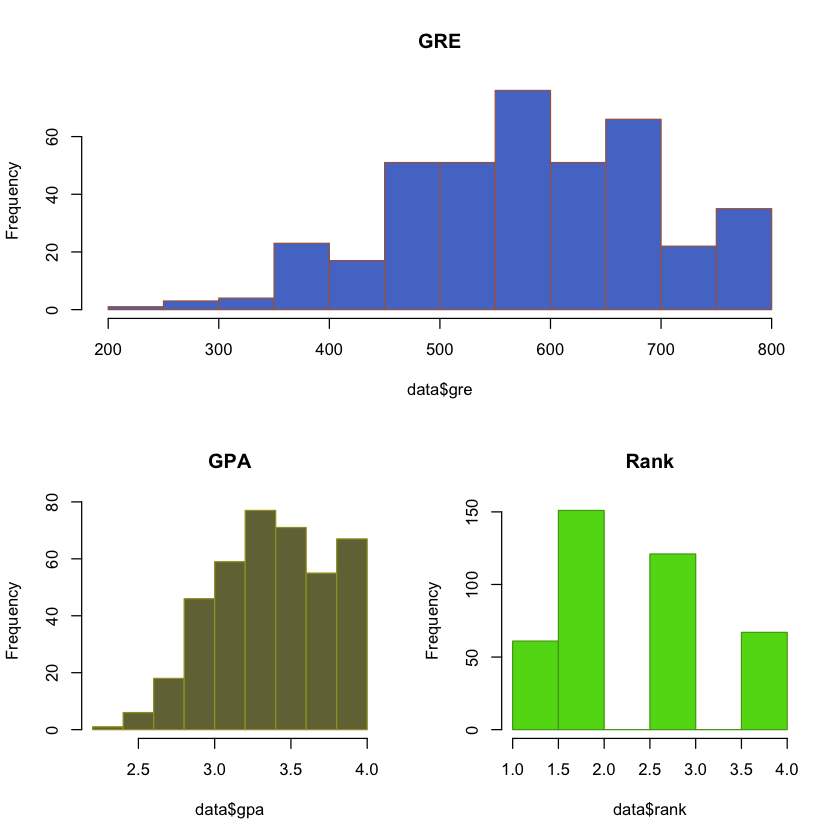

In [5]:
layout(layout.matrix)
hist(data$gre, col=rand.color(), border=rand.color(), main='GRE')
hist(data$gpa, col=rand.color(), border=rand.color(), main='GPA')
hist(data$rank, col=rand.color(), border=rand.color(), main='Rank')

In [6]:
lin.mod <- lm(admit ~ gre * gpa * rank, data=data)
lin.mod <- step(lin.mod, trace=0)
summary(lin.mod)


Call:
lm(formula = admit ~ gre + gpa + rank, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6617 -0.3417 -0.1947  0.5061  0.9556 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1824127  0.2169695  -0.841   0.4010    
gre          0.0004424  0.0002101   2.106   0.0358 *  
gpa          0.1510402  0.0633854   2.383   0.0176 *  
rank        -0.1095019  0.0237617  -4.608 5.48e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4448 on 396 degrees of freedom
Multiple R-squared:  0.09601,	Adjusted R-squared:  0.08916 
F-statistic: 14.02 on 3 and 396 DF,  p-value: 1.054e-08


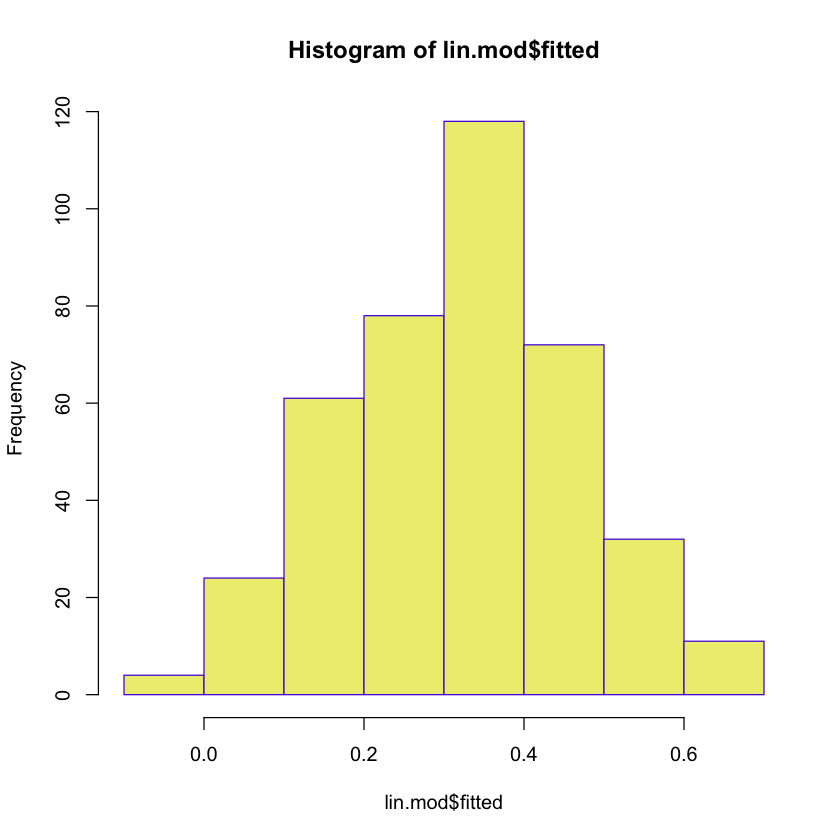

In [7]:
hist(lin.mod$fitted, col=rand.color(), border=rand.color())

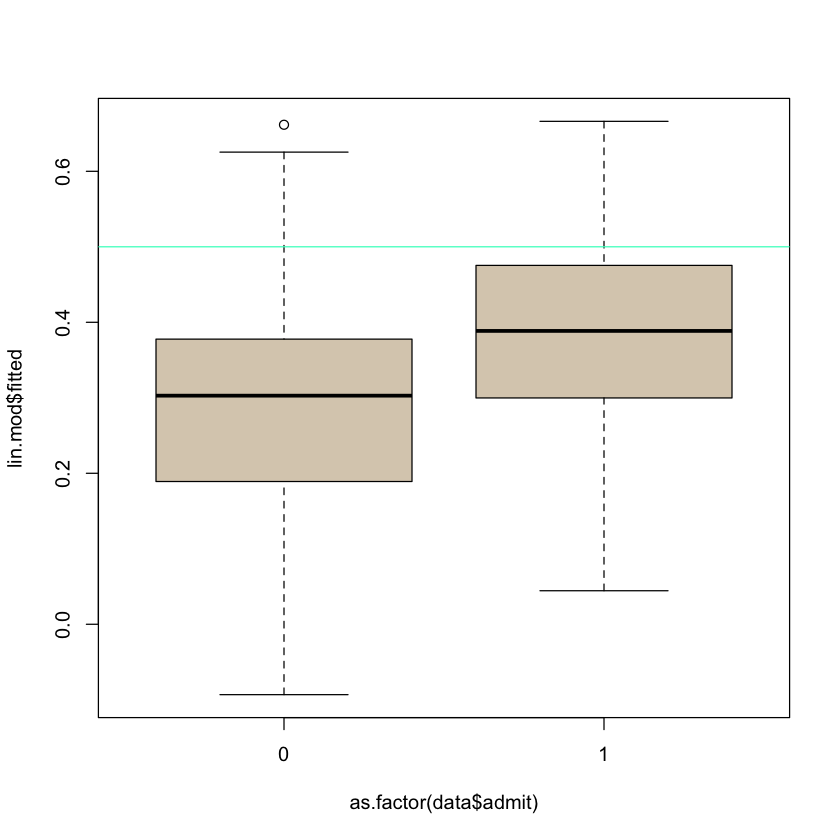

In [8]:
plot(lin.mod$fitted ~ as.factor(data$admit), col=rand.color())
abline(h=0.5, col=rand.color())

In [9]:
log.mod <- glm(admit ~ gre * gpa * rank, data=data, family='binomial')
log.mod <- step(log.mod, trace=0)
summary(log.mod)


Call:
glm(formula = admit ~ gre + gpa + rank + gre:gpa, family = "binomial", 
    data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4265  -0.9035  -0.6225   1.1625   2.2447  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -13.196328   6.046119  -2.183   0.0291 *  
gre           0.018507   0.009884   1.872   0.0611 .  
gpa           3.661045   1.779721   2.057   0.0397 *  
rank         -0.565757   0.127449  -4.439 9.03e-06 ***
gre:gpa      -0.004762   0.002875  -1.656   0.0976 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 456.60  on 395  degrees of freedom
AIC: 466.6

Number of Fisher Scoring iterations: 4


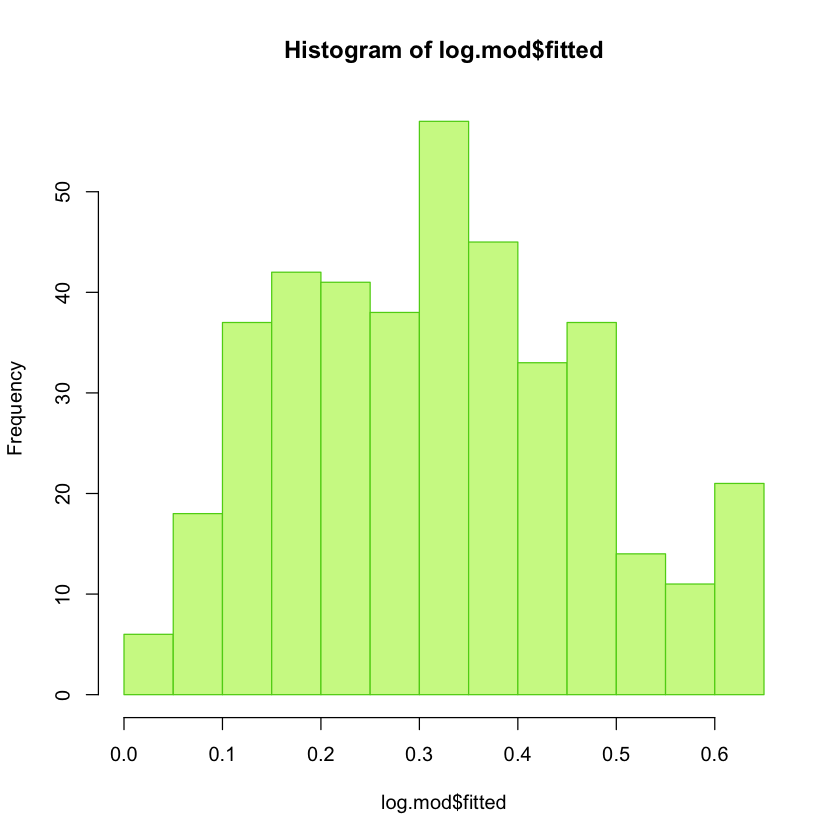

In [10]:
hist(log.mod$fitted, col=rand.color(), border=rand.color())

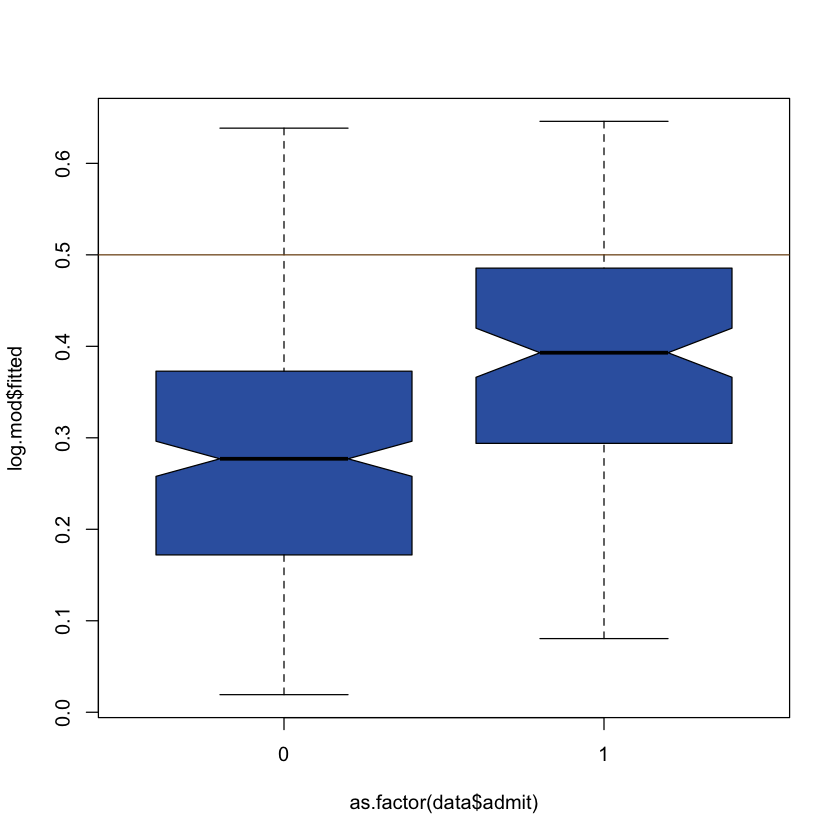

In [11]:
plot(log.mod$fitted ~ as.factor(data$admit), col=rand.color(), notch=T)
abline(h=0.5, col=rand.color())

In [12]:
table(data$admit, log.mod$fitted >= 0.5)

   
    FALSE TRUE
  0   256   17
  1    98   29

In [13]:
conf.matrix <- function(target, preds, threshold=0.5) {
  cm <- table(
    target, 1 * (preds >= threshold), dnn=c('Actual', 'Predicted'))
  cm
}

In [14]:
conf.matrix(data$admit, log.mod$fitted)

      Predicted
Actual   0   1
     0 256  17
     1  98  29

In [15]:
conf.matrix(data$admit, log.mod$fitted, threshold=0.35)

      Predicted
Actual   0   1
     0 185  88
     1  54  73

In [16]:
get.metrics <- function(cm) {
  tn <- cm['0', '0']
  fp <- cm['0', '1']
  fn <- cm['1', '0']
  tp <- cm['1', '1']
  # How many points did the model get right?
  accuracy <- (tp + tn) / sum(cm)
  # Of all cases the model predicted positive, how many actually were?
  precision <- tp / (tp + fp) 
  # Of all things actually positive, how many did the model get right?
  recall <- tp / (tp + fn)
  # A common metric for balancing precision and recall:
  f1 <- 2 * precision * recall / (precision + recall)
  list(acc=accuracy, prec=precision, rec=recall, f1=f1, tn=tn, fp=fp, 
       fn=fn, tp=tp)
}

In [17]:
get.metrics(conf.matrix(data$admit, log.mod$fitted))

$acc
[1] 0.7125

$prec
[1] 0.6304348

$rec
[1] 0.2283465

$f1
[1] 0.3352601

$tn
[1] 256

$fp
[1] 17

$fn
[1] 98

$tp
[1] 29

In [18]:
find.optimal.threshold <- function(
    actual, preds, criterion='acc', nvals=20, plt=T, ...) {
  thresholds <- seq(min(preds), max(preds), length=nvals + 2)
  thresholds <- thresholds[2:(length(thresholds) - 1)]
  metric <- numeric(nvals)
  for (i in 1:nvals) {
    metric[i] <- get.metrics(
        conf.matrix(actual, preds, threshold=thresholds[i]))[[criterion]]
  }
  if (plt) {
    plot(thresholds, metric, main=criterion, type='l', ...)
  }
  thresholds[which(metric == max(metric))]
}

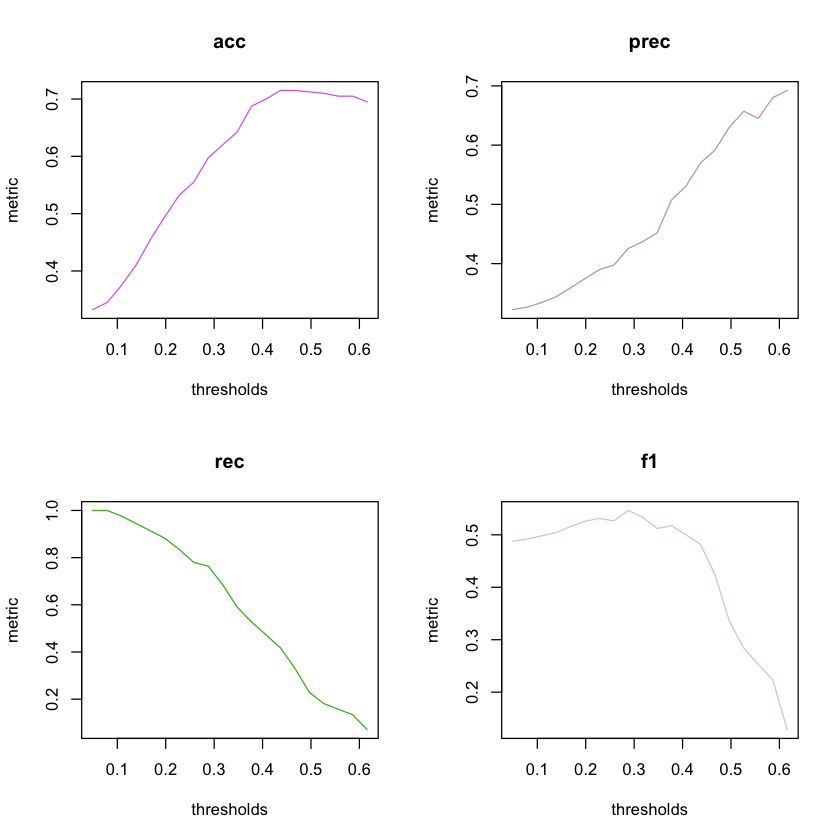

In [19]:
par(mfrow=c(2, 2))
for (criterion in c('acc', 'prec', 'rec', 'f1')) {
  find.optimal.threshold(
      data$admit, log.mod$fitted, criterion, col=rand.color())    
}

In [21]:
get.roc <- function(actual, preds, nvals=100, plt=T) {
  thresholds <- seq(min(preds), max(preds), length=nvals + 2)
  thresholds <- thresholds[2:(length(thresholds) - 1)]
  tp.rate <- numeric(nvals)
  fp.rate <- numeric(nvals)
  for (i in 1:nvals) {
    metrics <- get.metrics(
        conf.matrix(actual, preds, threshold=thresholds[i]))
    tp.rate[i] <- metrics$tp
    fp.rate[i] <- metrics$fp
  }
  # Normalize to be on [0, 1]
  tp.rate <- tp.rate / max(tp.rate)
  fp.rate <- fp.rate / max(fp.rate)
  if (plt) {
    plot(fp.rate, tp.rate, type='l')
    lines(c(0, 1), c(0, 1), col=2)
    lines(c(0, 0), c(0, 1))
    lines(c(0, 1), c(1, 1))
  }
  # If you want a challenge you can calcualate the AUC or "Area under
  # the Curve".
  # get.auc(fp.rate, tp.rate) # <- a function you write...
  # Or you can just use a library:
  AUC(preds, actual)
}

[1] 0.6958409

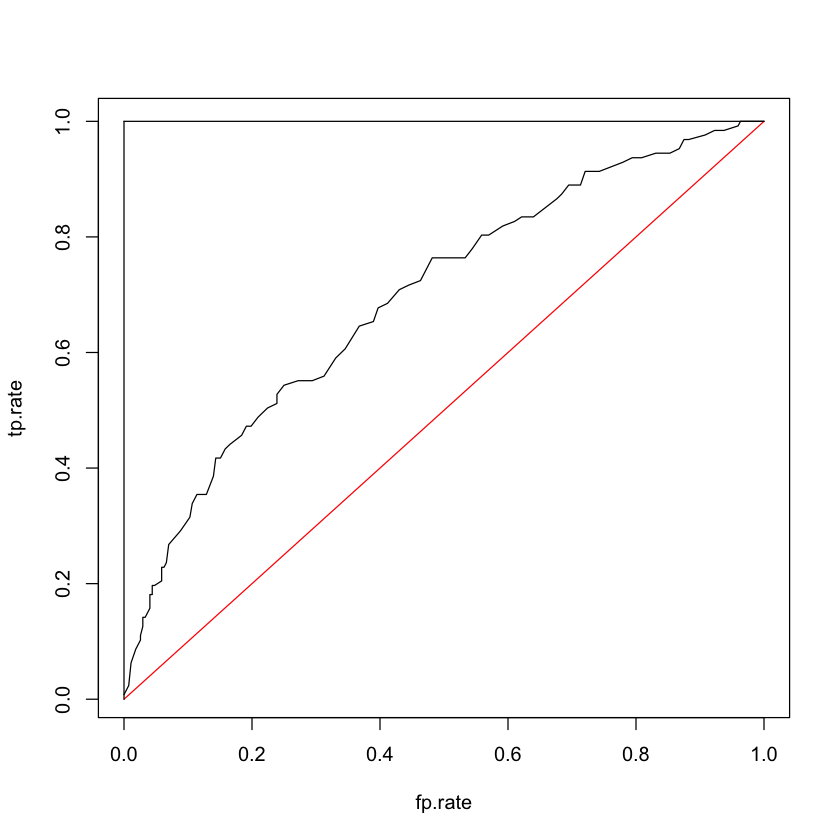

In [22]:
get.roc(data$admit, log.mod$fitted)

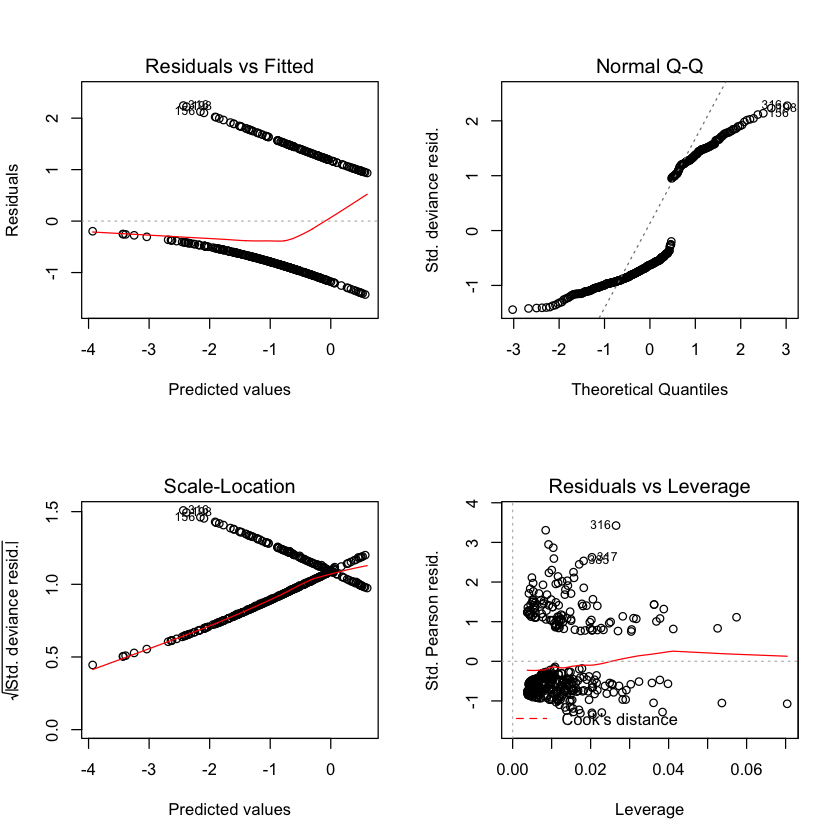

In [23]:
# What about model diagnostics for GLMs?
par(mfrow=c(2, 2))
plot(log.mod)

In [24]:
unit.scaler <- function(x) {
  x <- x - min(x)
  x / max(x)
}

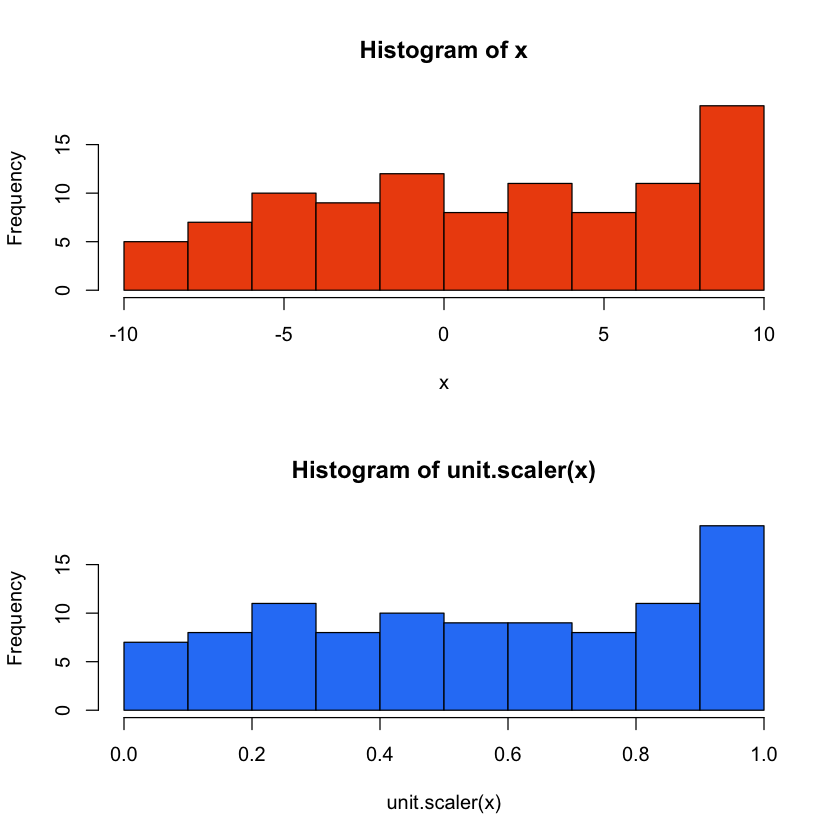

In [25]:
x <- runif(100, -10, 10)
par(mfrow=c(2, 1))
hist(x, col=rand.color())
hist(unit.scaler(x), col=rand.color())

In [26]:
# What would a perfect predictor look like?
pseudo.data <- data
for (field in c('gre', 'gpa', 'rank')) {
  pseudo.data[, field] <- unit.scaler(pseudo.data[, field])
}
head(pseudo.data)

admit,gre,gpa,rank
0,0.2758621,0.7758621,0.6666667
1,0.7586207,0.8103448,0.6666667
1,1.0000000,1.0000000,0.0000000
1,0.7241379,0.5344828,1.0000000
0,0.5172414,0.3850575,1.0000000
1,0.9310345,0.4252874,0.3333333


In [27]:
admit <- (
    0.33*pseudo.data$gre + 0.33*pseudo.data$gpa + 0.33*pseudo.data$rank)
pseudo.data$admit <- 1 * (admit >= 0.5)

In [28]:
head(pseudo.data)

admit,gre,gpa,rank
1,0.2758621,0.7758621,0.6666667
1,0.7586207,0.8103448,0.6666667
1,1.0000000,1.0000000,0.0000000
1,0.7241379,0.5344828,1.0000000
1,0.5172414,0.3850575,1.0000000
1,0.9310345,0.4252874,0.3333333


In [29]:
table(pseudo.data$admit)


  0   1 
113 287 

In [30]:
perfect.mod <- glm(
    admit ~ -1 + gre + gpa + rank, data=pseudo.data, family='binomial')
summary(perfect.mod)


Call:
glm(formula = admit ~ -1 + gre + gpa + rank, family = "binomial", 
    data = pseudo.data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9641  -1.3376   0.5245   0.6755   1.0757  

Coefficients:
     Estimate Std. Error z value Pr(>|z|)    
gre   -0.4399     0.5558  -0.791   0.4287    
gpa    1.2396     0.5558   2.230   0.0257 *  
rank   1.7376     0.3819   4.550 5.37e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 554.52  on 400  degrees of freedom
Residual deviance: 395.49  on 397  degrees of freedom
AIC: 401.49

Number of Fisher Scoring iterations: 4


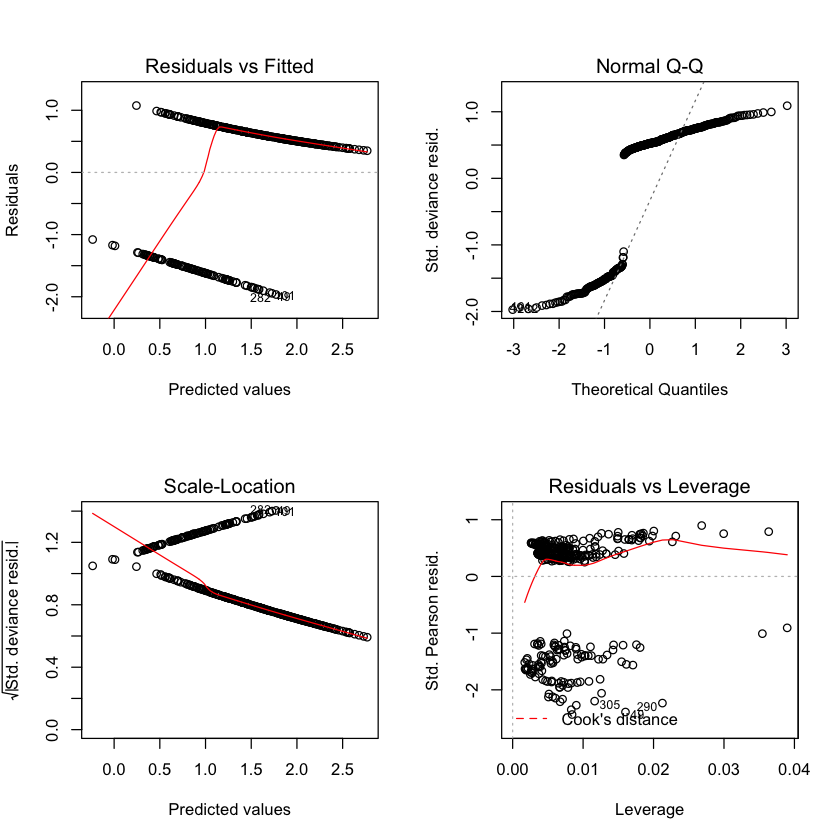

In [31]:
par(mfrow=c(2, 2))
plot(perfect.mod)

**BONUS QUESTION:** Why aren't all predictors significant?

# Other GLMs
### Response is Count Data (Poisson Distributed)

The following data set is from the Galapagos islands, and was from a study trying to understand speciation.

The response variables are `Species` -- the number of unique plant species on the different islands, and/or `Endemics` -- number of unique endemic species (e.g. found only in the region) on each island.
The predictors are:
- Area: km<super>2</super> of each island
- Elevation: highest point on each island (m)
- Nearest: distance (km) to nearest other island
- Scruz: distance (km) from Santa Cruz island (a relatively large central island) 
- Adjacent: Area of the nearest neigboring island

https://www.google.com/maps/place/Santa+Cruz+Island/@-0.2687564,-90.9521524,419833m/data=!3m1!1e3!4m5!3m4!1s0x9aaa5f3c9454fba5:0x900d7fee5795677f!8m2!3d-0.6393592!4d-90.3371889

In [32]:
data(gala) # in 'faraway' package
head(gala)

,Species,Endemics,Area,Elevation,Nearest,Scruz,Adjacent
Baltra,58,23,25.09,346,0.6,0.6,1.84
Bartolome,31,21,1.24,109,0.6,26.3,572.33
Caldwell,3,3,0.21,114,2.8,58.7,0.78
Champion,25,9,0.10,46,1.9,47.4,0.18
Coamano,2,1,0.05,77,1.9,1.9,903.82
Daphne.Major,18,11,0.34,119,8.0,8.0,1.84


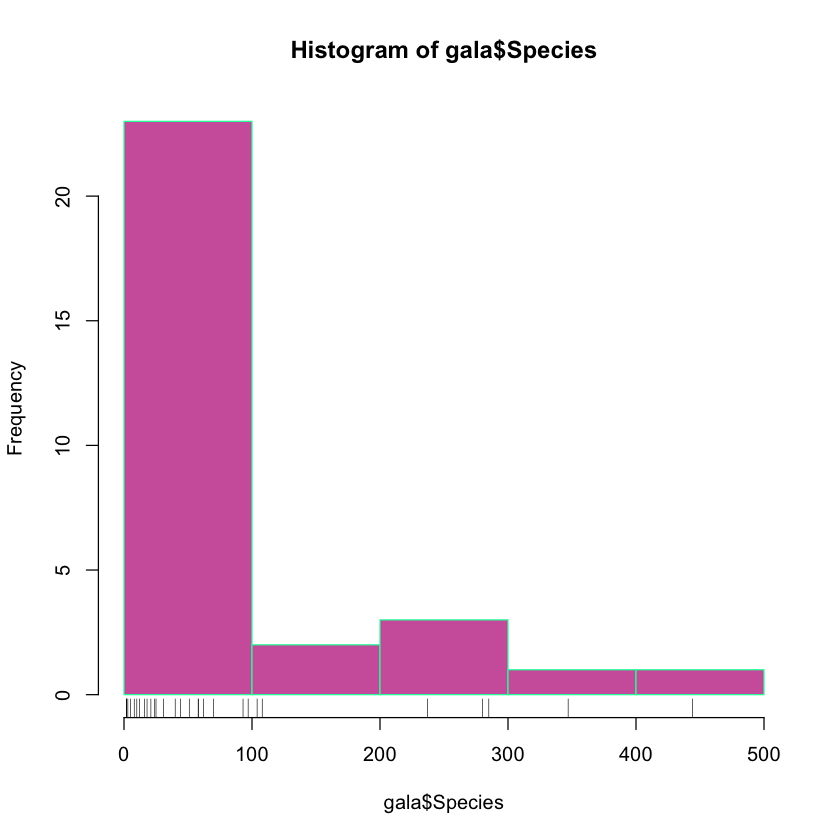

In [33]:
hist(gala$Species, col=rand.color(), border=rand.color())
rug(gala$Species)

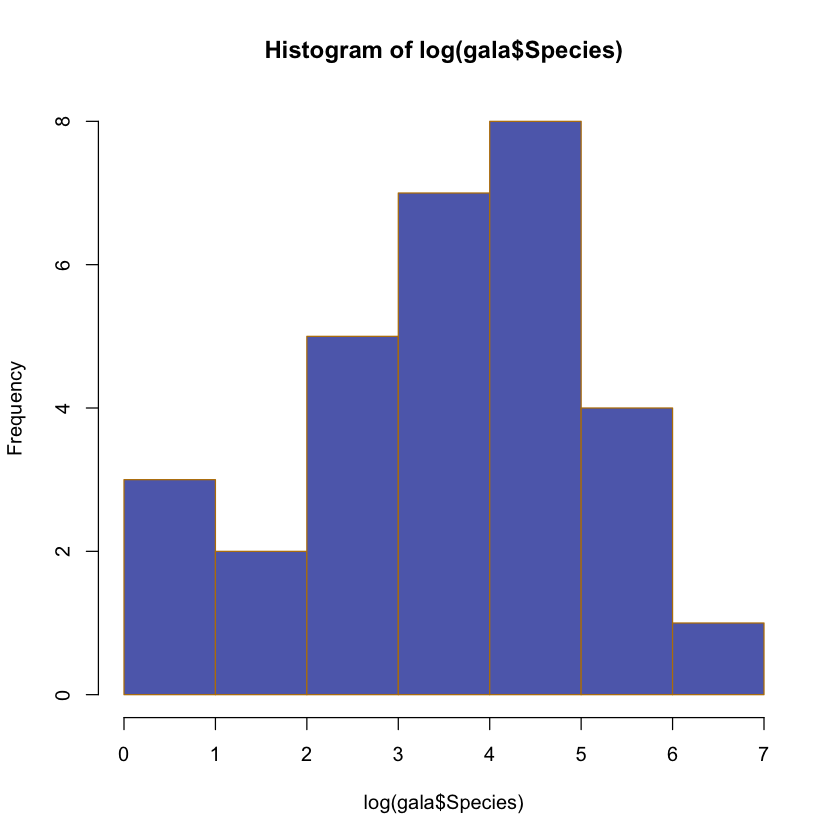

In [34]:
hist(log(gala$Species), col=rand.color(), border=rand.color())

In [35]:
transf.mod <- lm(
  log(Species) ~ Area + Elevation + Nearest + Scruz + Adjacent,
  data=gala)
transf.mod <- step(transf.mod, trace=0)
summary(transf.mod)


Call:
lm(formula = log(Species) ~ Area + Elevation + Adjacent, data = gala)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0544 -0.5149  0.1771  0.6785  1.6584 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.2253101  0.2871870   7.749 3.20e-08 ***
Area        -0.0007798  0.0003705  -2.104   0.0452 *  
Elevation    0.0046646  0.0008852   5.270 1.65e-05 ***
Adjacent    -0.0008823  0.0002884  -3.059   0.0051 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.036 on 26 degrees of freedom
Multiple R-squared:  0.6061,	Adjusted R-squared:  0.5606 
F-statistic: 13.33 on 3 and 26 DF,  p-value: 1.832e-05


Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”Warning message in sqrt(crit * p * (1 - hh)/hh):
“NaNs produced”

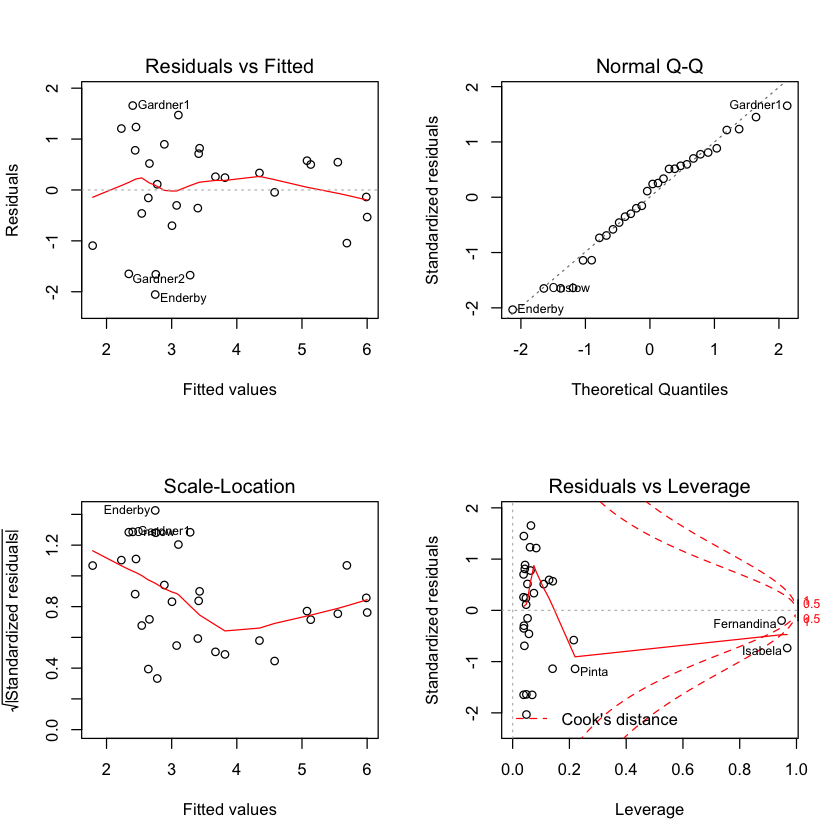

In [36]:
par(mfrow=c(2, 2))
plot(transf.mod)

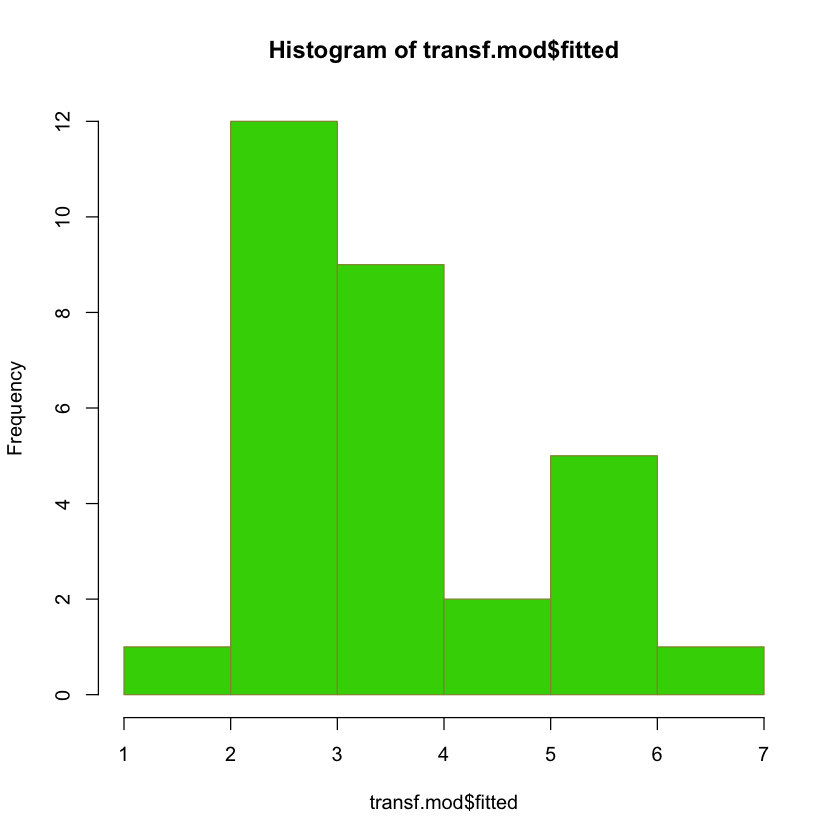

In [37]:
hist(transf.mod$fitted, col=rand.color(), border=rand.color())

In [38]:
# But a note of caution:
n <- 50
fake.data <- data.frame(
  'Area'=sample(gala$Area, n, replace=T) 
    + abs(rnorm(n, 0, sd(gala$Area))),
  'Elevation'=sample(gala$Elevation, n, replace=T) 
    + abs(rnorm(n, 0, sd(gala$Elevation))),
  'Adjacent'=sample(gala$Adjacent, n, replace=T) 
    + abs(rnorm(n, 0, sd(gala$Adjacent))))
head(fake.data)

Area,Elevation,Adjacent
397.4018,1166.9170,686.9126
1211.4304,2094.2701,335.2378
428.9372,2251.6285,522.2038
1742.0083,1685.8947,966.1635
501.0288,106.0287,2438.6482
326.3579,1339.4759,971.3721


In [39]:
?predict.lm

In [42]:
preds <- predict(transf.mod, newdata=fake.data, type='response', se.fit=T)
# Don't forget to transform back
preds.fit <- exp(preds$fit)
upper95 <- exp(preds$fit + 1.96*preds$se.fit)
lower95 <- exp(preds$fit - 1.96*preds$se.fit)

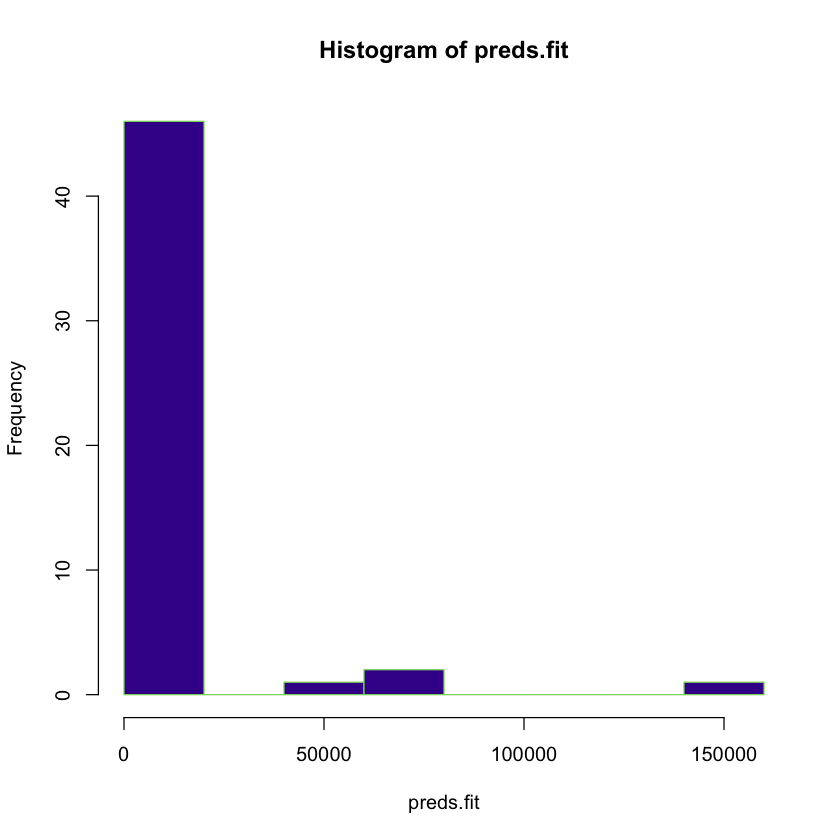

In [43]:
hist(preds.fit, col=rand.color(), border=rand.color())

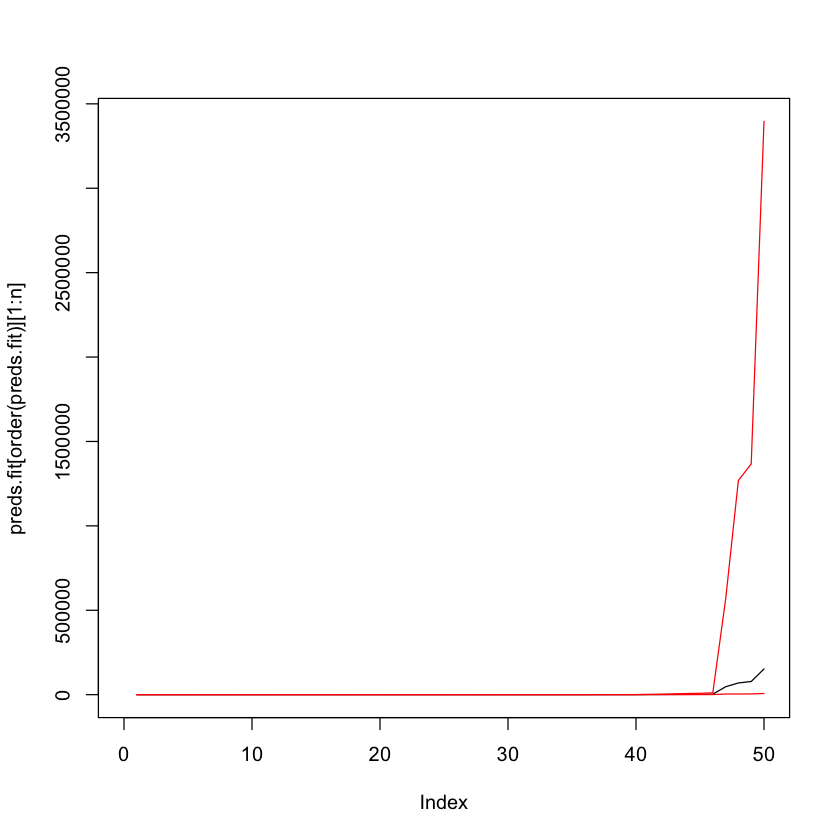

In [46]:
# But remember that *errors* are not normally distributed, 
# *log(error)* are normally distributed
n <- 50 # <- try plotting larger values (up to 50)
plot(preds.fit[order(preds.fit)][1:n], 
     type='l', 
     ylim=c(0, max(upper95[order(preds.fit)][1:n])), 
     xlim=c(0, n))
lines(upper95[order(preds.fit)][1:n], col=2)
lines(lower95[order(preds.fit)][1:n], col=2)

In [47]:
pois.mod <- glm(
  Species ~ Area + Elevation + Adjacent,
  data=gala,
  family='poisson')
pois.mod <- step(pois.mod, trace=0)
summary(pois.mod)


Call:
glm(formula = Species ~ Area + Elevation + Adjacent, family = "poisson", 
    data = gala)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-11.852   -4.248   -1.013    2.466   10.607  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  2.961e+00  4.773e-02   62.05   <2e-16 ***
Area        -5.703e-04  2.518e-05  -22.65   <2e-16 ***
Elevation    3.589e-03  8.608e-05   41.70   <2e-16 ***
Adjacent    -7.508e-04  2.778e-05  -27.03   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 3510.73  on 29  degrees of freedom
Residual deviance:  818.74  on 26  degrees of freedom
AIC: 987.57

Number of Fisher Scoring iterations: 5


In [48]:
preds <- predict(pois.mod, newdata=fake.data, type='response', se.fit=T)

In [49]:
preds.fit <- preds$fit
upper95 <- preds$fit + 1.96*preds$se.fit
lower95 <- preds$fit - 1.96*preds$se.fit

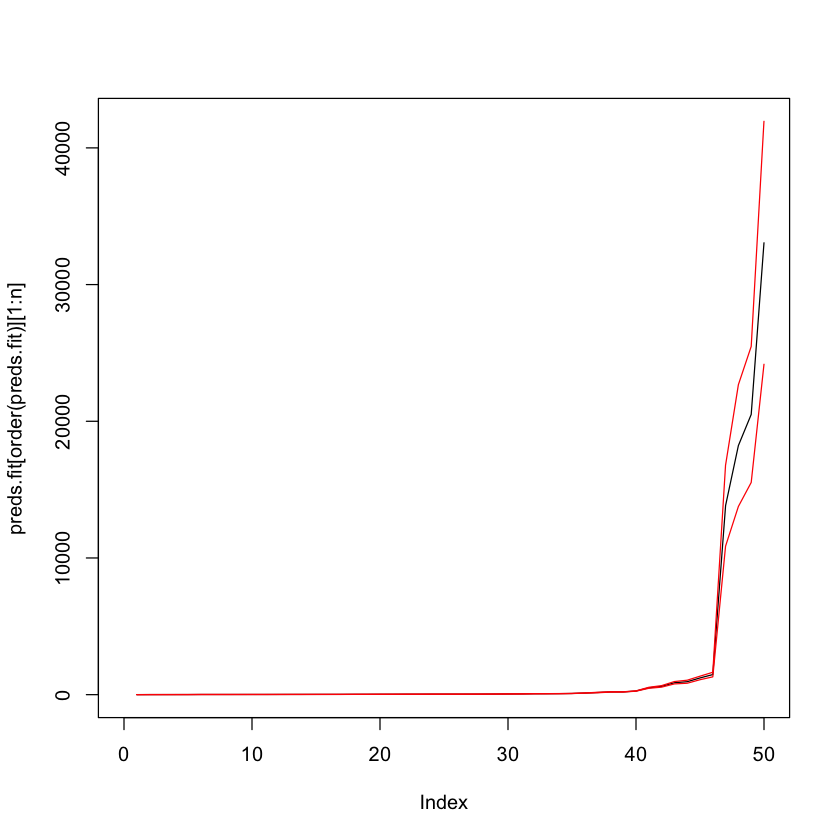

In [51]:
n <- 50 # <- try plotting larger values (up to 50)
plot(preds.fit[order(preds.fit)][1:n], 
     type='l', 
     ylim=c(0, max(upper95[order(preds.fit)][1:n])), 
     xlim=c(0, n))
lines(upper95[order(preds.fit)][1:n], col=2)
lines(lower95[order(preds.fit)][1:n], col=2)